In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [19]:
# --- 1. Data Generation and Price Forecasting ---

def generate_energy_data(days=1, forecast_volatility_factor=1.0):
    """Generates synthetic hourly data for a 24-hour period, including a price forecast."""
    
    # 1. Historical Data (Simple Linear Relationship)
    X_hist = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
    # Historical Price (€/MWh), adjusted by volatility factor for scenario analysis
    y_hist = np.array([50, 75, 60, 90, 80, 110]) * forecast_volatility_factor 

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X_hist, y_hist)

    # 2. 24-Hour Price Forecast
    X_forecast = np.arange(60, 60 + days * 24 * 10, 10).reshape((-1, 1)) 
    prices = model.predict(X_forecast)

    # Simulate realistic price fluctuations (Price Volatility)
    noise = np.random.normal(0, 5 * forecast_volatility_factor, prices.shape)
    prices += noise
    prices[prices < 0] = 5 # Ensure no negative prices
    
    # Generate Synthetic Frequency Data (for Balancing Market)
    frequency_data = np.full(len(prices), 50.00)
    # Simulate low/high frequency events for aFRR/FCR revenue stacking
    frequency_data[np.random.randint(0, len(prices), int(len(prices)*0.1))] = 49.975 
    frequency_data[np.random.randint(0, len(prices), int(len(prices)*0.1))] = 50.030 
    
    return prices, frequency_data, model

In [20]:
# --- 2. BESS Operational Logic (Revenue Stacking) ---

def bess_operational_model(prices, frequencies, capacity_mwh, initial_soc, eff, max_c_rate):
    """
    Combines price arbitrage and balancing market (FCR/aFRR) decisions 
    to maximize short-term profit.
    """
    
    capacity = capacity_mwh 
    charge_level = initial_soc * capacity
    
    # Parameters for Arbitrage 
    avg_price = prices.mean()
    max_arb_power = max_c_rate * capacity 
    
    # Parameters for Balancing Market
    REF_FREQ = 50.00
    FCR_THRESHOLD = 0.02
    
    total_profit = 0
    decisions = []
    charge_levels_over_time = [charge_level]
    reserve_contract_payment_per_hour = 50 # Revenue from reserve capacity (fixed)
    
    for i, price in enumerate(prices):
        freq = frequencies[i]
        power_from_reserve = 0 
        
        # --- A. Balancing Market (Highest Priority) ---
        freq_dev = freq - REF_FREQ
        if abs(freq_dev) > FCR_THRESHOLD:
            # FCR/aFRR Power needed is proportional to deviation
            power_needed = -freq_dev * 1000 
            power_from_reserve = max(min(power_needed, max_arb_power), -max_arb_power)
            
            # Balancing Market Revenue: Payment for service delivery
            reserve_revenue = abs(power_from_reserve) * 200 * 1 
            total_profit += reserve_revenue
            decisions.append('FCR/aFRR')
        
        # --- B. Price Arbitrage (Secondary Priority) ---
        else:
            if price < avg_price * 0.9 and charge_level < capacity:
                # Charge (Buy Low)
                power_arb = min(capacity - charge_level, max_arb_power)
                total_profit -= power_arb * price  # Cost
                charge_level += power_arb * eff
                decisions.append('Charge (Arb)')
                
            elif price > avg_price * 1.1 and charge_level > 0:
                # Discharge (Sell High)
                power_arb = min(charge_level, max_arb_power)
                total_profit += power_arb * eff * price  # Revenue
                charge_level -= power_arb
                decisions.append('Discharge (Arb)')
                
            else:
                decisions.append('Hold')
        
        # Apply energy change from Balancing Market (if active)
        if power_from_reserve > 0: # Discharge
            energy_change = min(charge_level, power_from_reserve)
            total_profit += energy_change * eff * price 
            charge_level -= energy_change
            
        elif power_from_reserve < 0: # Charge
            energy_change = min(capacity - charge_level, -power_from_reserve)
            total_profit -= energy_change * price 
            charge_level += energy_change * eff
            
        # State of Charge (SOC) constraint
        charge_level = np.clip(charge_level, 0, capacity)
        charge_levels_over_time.append(charge_level)
    
    # Calculate revenue from reserve capacity payment (paid regardless of dispatch)
    reserve_capacity_revenue = len(prices) * reserve_contract_payment_per_hour * capacity_mwh
    total_profit += reserve_capacity_revenue
    
    return total_profit, decisions, charge_levels_over_time, avg_price

In [21]:
# --- 3. Financial Modeling (IRR, LCOE, NPV) ---

def financial_analysis(daily_profit, system_cost, lifetime_years, initial_soc, degradation_factor, discount_rate, capacity_mwh, eff):
    """Calculates key financial metrics for BESS investment (IRR, LCOE, NPV, Discounting Rate)."""
    
    DAYS_IN_YEAR = 365
    CYCLES_PER_YEAR = 300 
    
    annual_profit = daily_profit * DAYS_IN_YEAR
    
    # Create cash flow stream (including initial investment and annual degradation)
    cash_flows = [-system_cost]
    for year in range(1, lifetime_years + 1):
        # Discount the annual profit and apply degradation factor (Cycle Life/DOD impact)
        cf = annual_profit * (1 / (1 + discount_rate)**year) * (degradation_factor**year)
        cash_flows.append(cf)
    
    # --- 1. Net Present Value (NPV) ---
    npv = np.sum(cash_flows)
    
    # --- 2. Internal Rate of Return (IRR) ---
    try:
        irr = np.irr(np.array([-system_cost] + [annual_profit * (degradation_factor**y) for y in range(lifetime_years)]))
    except:
        irr = -99.99
    
    # --- 3. Levelized Cost of Energy (LCOE) ---
    # LCOE = (Total Lifetime Costs) / (Total Lifetime Energy Delivered)
    total_energy_delivered = CYCLES_PER_YEAR * capacity_mwh * lifetime_years * eff
    total_lifetime_cost = system_cost 
    lcoe = total_lifetime_cost / total_energy_delivered # Price in €/MWh
    
    return npv, irr, lcoe

In [22]:
# --- 4. Sensitivity Analysis Function ---

def run_sensitivity_analysis(base_params, sensitivity_ranges):
    """Runs the full model across a range of key variables and stores NPV and IRR results."""
    
    results = {'NPV': {}, 'IRR': {}}
    
    # Unpack base parameters
    (BESS_CAPACITY_MWH, BESS_COST, LIFETIME_YEARS, INITIAL_SOC, 
     ROUND_TRIP_EFFICIENCY, DISCOUNT_RATE, MAX_C_RATE) = base_params

    # Generate the base price and frequency data once
    base_prices, base_freqs, _ = generate_energy_data(days=1, forecast_volatility_factor=1.0)
    
    # --- Sensitivity Loop ---
    for param, values in sensitivity_ranges.items():
        npv_list = []
        irr_list = []
        
        for value in values:
            
            # Adjust parameters based on the variable being tested
            cost_test = BESS_COST
            eff_test = ROUND_TRIP_EFFICIENCY
            
            if param == 'Cost':
                cost_test = value
                
            elif param == 'Efficiency':
                eff_test = value
                
            elif param == 'Volatility':
                prices_test, freqs_test, _ = generate_energy_data(days=1, forecast_volatility_factor=value)
            else:
                prices_test = base_prices
                freqs_test = base_freqs
            
            # 1. Run Operational Model
            if param == 'Volatility':
                daily_profit, _, _, _ = bess_operational_model(
                    prices_test, freqs_test, BESS_CAPACITY_MWH, INITIAL_SOC, eff_test, MAX_C_RATE
                )
            else:
                 daily_profit, _, _, _ = bess_operational_model(
                    base_prices, base_freqs, BESS_CAPACITY_MWH, INITIAL_SOC, eff_test, MAX_C_RATE
                )
                
            # 2. Run Financial Analysis
            npv, irr, _ = financial_analysis(
                daily_profit, cost_test, LIFETIME_YEARS, INITIAL_SOC, 0.98, DISCOUNT_RATE,
                BESS_CAPACITY_MWH, eff_test 
            )
            
            npv_list.append(npv)
            irr_list.append(irr)
            
        results['NPV'][param] = (values, npv_list)
        results['IRR'][param] = (values, irr_list)

    return results

In [14]:
# --- 5. Main Execution and Scenario/Sensitivity Analysis ---

# --- System & Financial Inputs ---
BESS_CAPACITY_MWH = 50           # BESS Size (MWh)
BESS_COST = 20_000_000           # Initial System Cost (€)
LIFETIME_YEARS = 15              # Project Lifetime (years)
INITIAL_SOC = 0.70               # Initial State of Charge (70%)
ROUND_TRIP_EFFICIENCY = 0.90     # Round Trip Efficiency (eff)
DISCOUNT_RATE = 0.08             # Discounting Rate (8%)
MAX_C_RATE = 0.5                 # Max Charge/Discharge Rate (0.5C)

BASE_PARAMS = (BESS_CAPACITY_MWH, BESS_COST, LIFETIME_YEARS, INITIAL_SOC, 
               ROUND_TRIP_EFFICIENCY, DISCOUNT_RATE, MAX_C_RATE)

# --- Define Sensitivity Ranges ---
SENSITIVITY_RANGES = {
    'Cost': np.linspace(BESS_COST * 0.9, BESS_COST * 1.1, 5), # +/- 10% Cost
    'Efficiency': np.linspace(0.85, 0.95, 5),                 # 85% to 95% RTE
    'Volatility': np.linspace(0.7, 1.3, 5)                    # Low to High Volatility Factor
}

# --- Run Scenario and Sensitivity Analysis ---

# Scenario 1: P50 (Median Case) - Base Case for Sensitivity
P50_PRICES, P50_FREQS, _ = generate_energy_data(days=1, forecast_volatility_factor=1.0)
P50_PROFIT, P50_DECISIONS, P50_SOC, P50_AVG_PRICE = bess_operational_model(
    P50_PRICES, P50_FREQS, BESS_CAPACITY_MWH, INITIAL_SOC, ROUND_TRIP_EFFICIENCY, MAX_C_RATE
)
P50_NPV, P50_IRR, P50_LCOE = financial_analysis(
    P50_PROFIT, BESS_COST, LIFETIME_YEARS, INITIAL_SOC, 0.98, DISCOUNT_RATE,
    BESS_CAPACITY_MWH, ROUND_TRIP_EFFICIENCY
)

# Scenario 2: P99 (Worst Case)
P99_PRICES, P99_FREQS, _ = generate_energy_data(days=1, forecast_volatility_factor=0.8)
P99_PROFIT, P99_DECISIONS, P99_SOC, P99_AVG_PRICE = bess_operational_model(
    P99_PRICES, P99_FREQS, BESS_CAPACITY_MWH, INITIAL_SOC, ROUND_TRIP_EFFICIENCY, MAX_C_RATE
)
P99_NPV, P99_IRR, P99_LCOE = financial_analysis(
    P99_PROFIT, BESS_COST, LIFETIME_YEARS, INITIAL_SOC, 0.95, DISCOUNT_RATE,
    BESS_CAPACITY_MWH, ROUND_TRIP_EFFICIENCY
)

# Run Sensitivity Analysis
sensitivity_results = run_sensitivity_analysis(BASE_PARAMS, SENSITIVITY_RANGES)





--- Sensitivity Analysis Complete ---
Generated plots: npv_sensitivity.png and irr_sensitivity.png


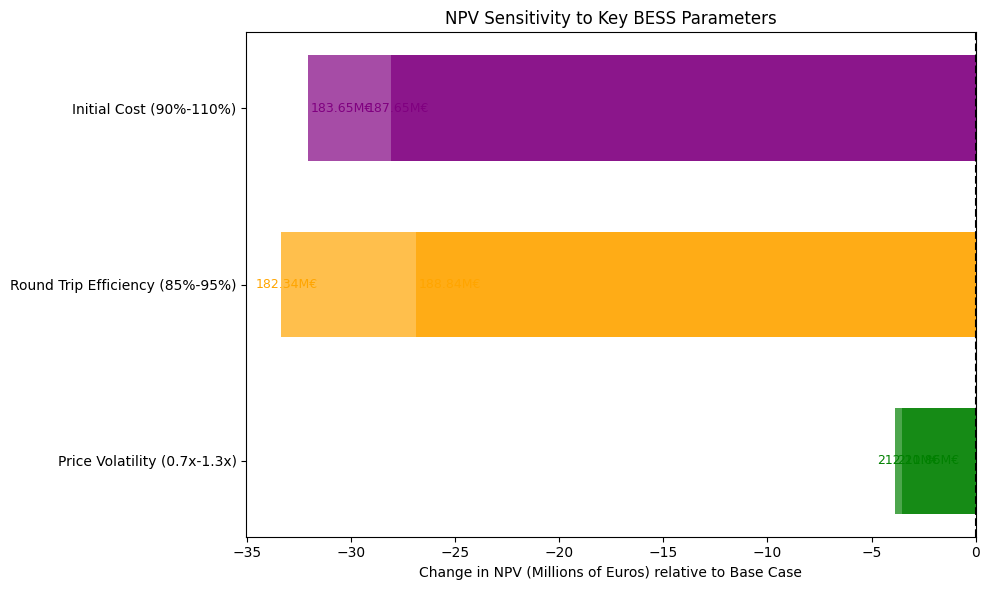

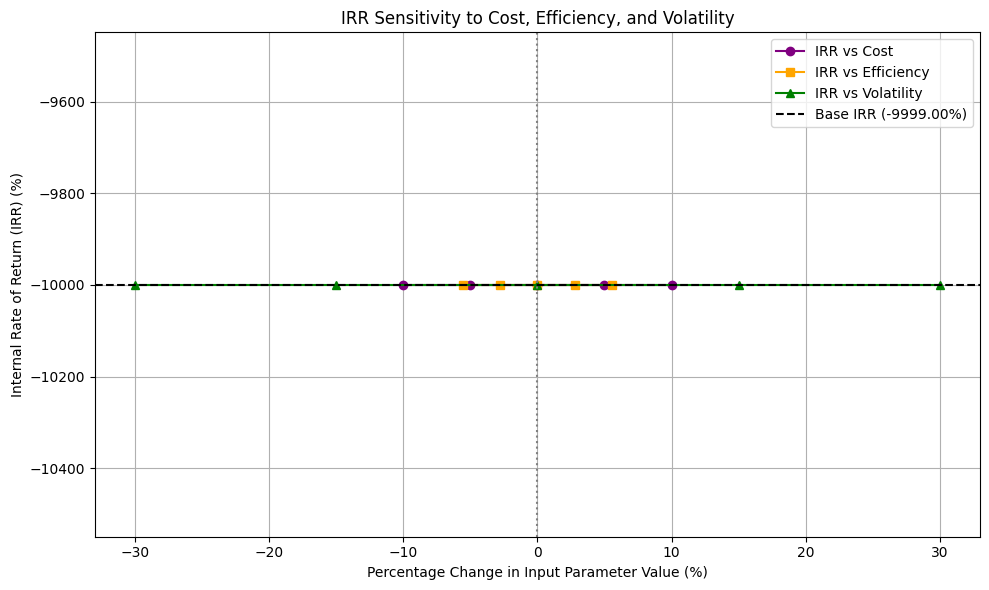

In [18]:
# --- 6. Plotting Sensitivity Results (New Graphs) ---

# --- Plot 3: NPV Sensitivity (Tornado Chart Style) ---
plt.figure(figsize=(10, 6))
base_npv = P50_NPV
y_pos = np.arange(len(SENSITIVITY_RANGES))
height = 0.6
colors = ['purple', 'orange', 'green']

for i, (param, (values, npvs)) in enumerate(sensitivity_results['NPV'].items()):
    # Calculate difference from base case
    min_diff = (npvs[0] - base_npv) / 1000000
    max_diff = (npvs[-1] - base_npv) / 1000000
    
    plt.barh(y_pos[i], max_diff, height=height, left=0, color=colors[i], alpha=0.7, label=f'{param} Range Max')
    plt.barh(y_pos[i], min_diff, height=height, left=0, color=colors[i], alpha=0.7)
    
    # Add text for the range values
    plt.text(max_diff + 0.1, y_pos[i], f'{npvs[-1]/1e6:.2f}M€', va='center', fontsize=9, color=colors[i])
    plt.text(min_diff - 1.2, y_pos[i], f'{npvs[0]/1e6:.2f}M€', va='center', fontsize=9, color=colors[i])

plt.axvline(0, color='black', linestyle='--')
plt.yticks(y_pos, ['Initial Cost (90%-110%)', 'Round Trip Efficiency (85%-95%)', 'Price Volatility (0.7x-1.3x)'])
plt.xlabel('Change in NPV (Millions of Euros) relative to Base Case')
plt.title('NPV Sensitivity to Key BESS Parameters')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('npv_sensitivity.png')

# --- Plot 4: IRR Sensitivity vs. Variable Change (Spider/Line Plot) ---
plt.figure(figsize=(10, 6))
base_irr = P50_IRR
markers = ['o', 's', '^']

for i, (param, (values, irrs)) in enumerate(sensitivity_results['IRR'].items()):
    
    # Normalize X-axis to show change relative to base parameter
    if param == 'Cost':
        x_norm = (values / BESS_COST) - 1.0 # -0.1 to 0.1
        label = 'Investment Cost Change'
    elif param == 'Efficiency':
        x_norm = (values / ROUND_TRIP_EFFICIENCY) - 1.0 # approx -0.05 to 0.05
        label = 'RTE Change'
    else: # Volatility
        x_norm = values - 1.0 # -0.3 to 0.3
        label = 'Volatility Factor Change'
        
    plt.plot(x_norm * 100, np.array(irrs) * 100, marker=markers[i], linestyle='-', 
             label=f'IRR vs {param}', color=colors[i])

plt.axhline(base_irr * 100, color='black', linestyle='--', label=f'Base IRR ({base_irr*100:.2f}%)')
plt.axvline(0, color='gray', linestyle=':')
plt.xlabel('Percentage Change in Input Parameter Value (%)')
plt.ylabel('Internal Rate of Return (IRR) (%)')
plt.title('IRR Sensitivity to Cost, Efficiency, and Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('irr_sensitivity.png')

print("\n--- Sensitivity Analysis Complete ---")
print("Generated plots: npv_sensitivity.png and irr_sensitivity.png")